# Imports

In [1]:
import numpy as np
from SEDer import band_retrieval_routines as brr
from SEDer import sed_routines as sr
from SEDer import extinction_routines as er
from SEDer import fitting_routines as fr
from astropy.table import Table
from astropy import units as u
from os import path

# Read models

In [2]:
kurucz = Table(np.genfromtxt(path.join('../SEDer', 'models', 'kurucz_sed.dat'), names=True, dtype=None))
koester = Table(np.genfromtxt(path.join('../SEDer', 'models', 'koester_sed.dat'), names=True, dtype=None))
co_da  = Table(np.genfromtxt(path.join('../SEDer', 'models', 'CO_DA.dat'), names=True, dtype=None))
co_db  = Table(np.genfromtxt(path.join('../SEDer', 'models', 'CO_DB.dat'), names=True, dtype=None))
he_da  = Table(np.genfromtxt(path.join('../SEDer', 'models', 'He_wd.dat'), names=True, dtype=None))
one_da = Table(np.genfromtxt(path.join('../SEDer', 'models', 'ONe_DA.dat'), names=True, dtype=None))
one_db = Table(np.genfromtxt(path.join('../SEDer', 'models', 'ONe_DB.dat'), names=True, dtype=None))

# Get observed photometry for a Gaia source

In [ ]:
# The source ID of Gaia BH2
sid = 5870569352746779008

In [ ]:
# Retrieve the photometry
obs,flags = brr.get_photometry_single_source(sid, snr_lim=10)

In [ ]:
# We know it is in a binary, so we need to replace the parallax
# to the one obtained by Gaia DR3 NSS
orb = sr.get_orbital_parameters(sid)
obs['parallax'] = orb[0]
obs['parallax_error'] = orb[1]

# SED models

In [6]:
ms = sr.get_MS_sed(teff=5900, m1=1 , r1=1, meta=0, parallax=1.1538)
wd = sr.get_wd_bedard_sed(teff=10000, m=0.3, parallax=1.1538, core='He',atm='H')

# SED fitting

In [7]:

# Fixed parameters for fit; should be determined from prior knowledge
meta = -0.5
av = er.query_extinction(sid)

# bands to ignore in the fit. Options:
# 'GALEX.FUV', 'GALEX.NUV', 'GAIA3.Gbp', 'GAIA3.G', 'GAIA3.Grp'
# 'Johnson.U', 'Johnson.B', 'Johnson.V', 'Johnson.R', 'Johnson.I'
# 'SDSS.u', 'SDSS.g', 'SDSS.r', 'SDSS.i', 'SDSS.z'
# '2MASS.J', '2MASS.H', '2MASS.Ks', 'WISE.W1', 'WISE.W2', 'WISE.W3'

bands_to_ignore = ['GALEX.NUV','WISE.W1','WISE.W2','WISE.W3']

teff, teff_err, radius, radius_err, logg, logg_err, chi2 = fr.fit_RG_RTlogg(obs, meta, av,
                                                    init_guess=[6000, 8, 2], bounds=[(3500, 0.1, 1), (10000, 25, 3.5)], bands_to_ignore=[])

In [8]:
fit_results = (teff,teff_err,radius,radius_err,logg,logg_err,chi2)

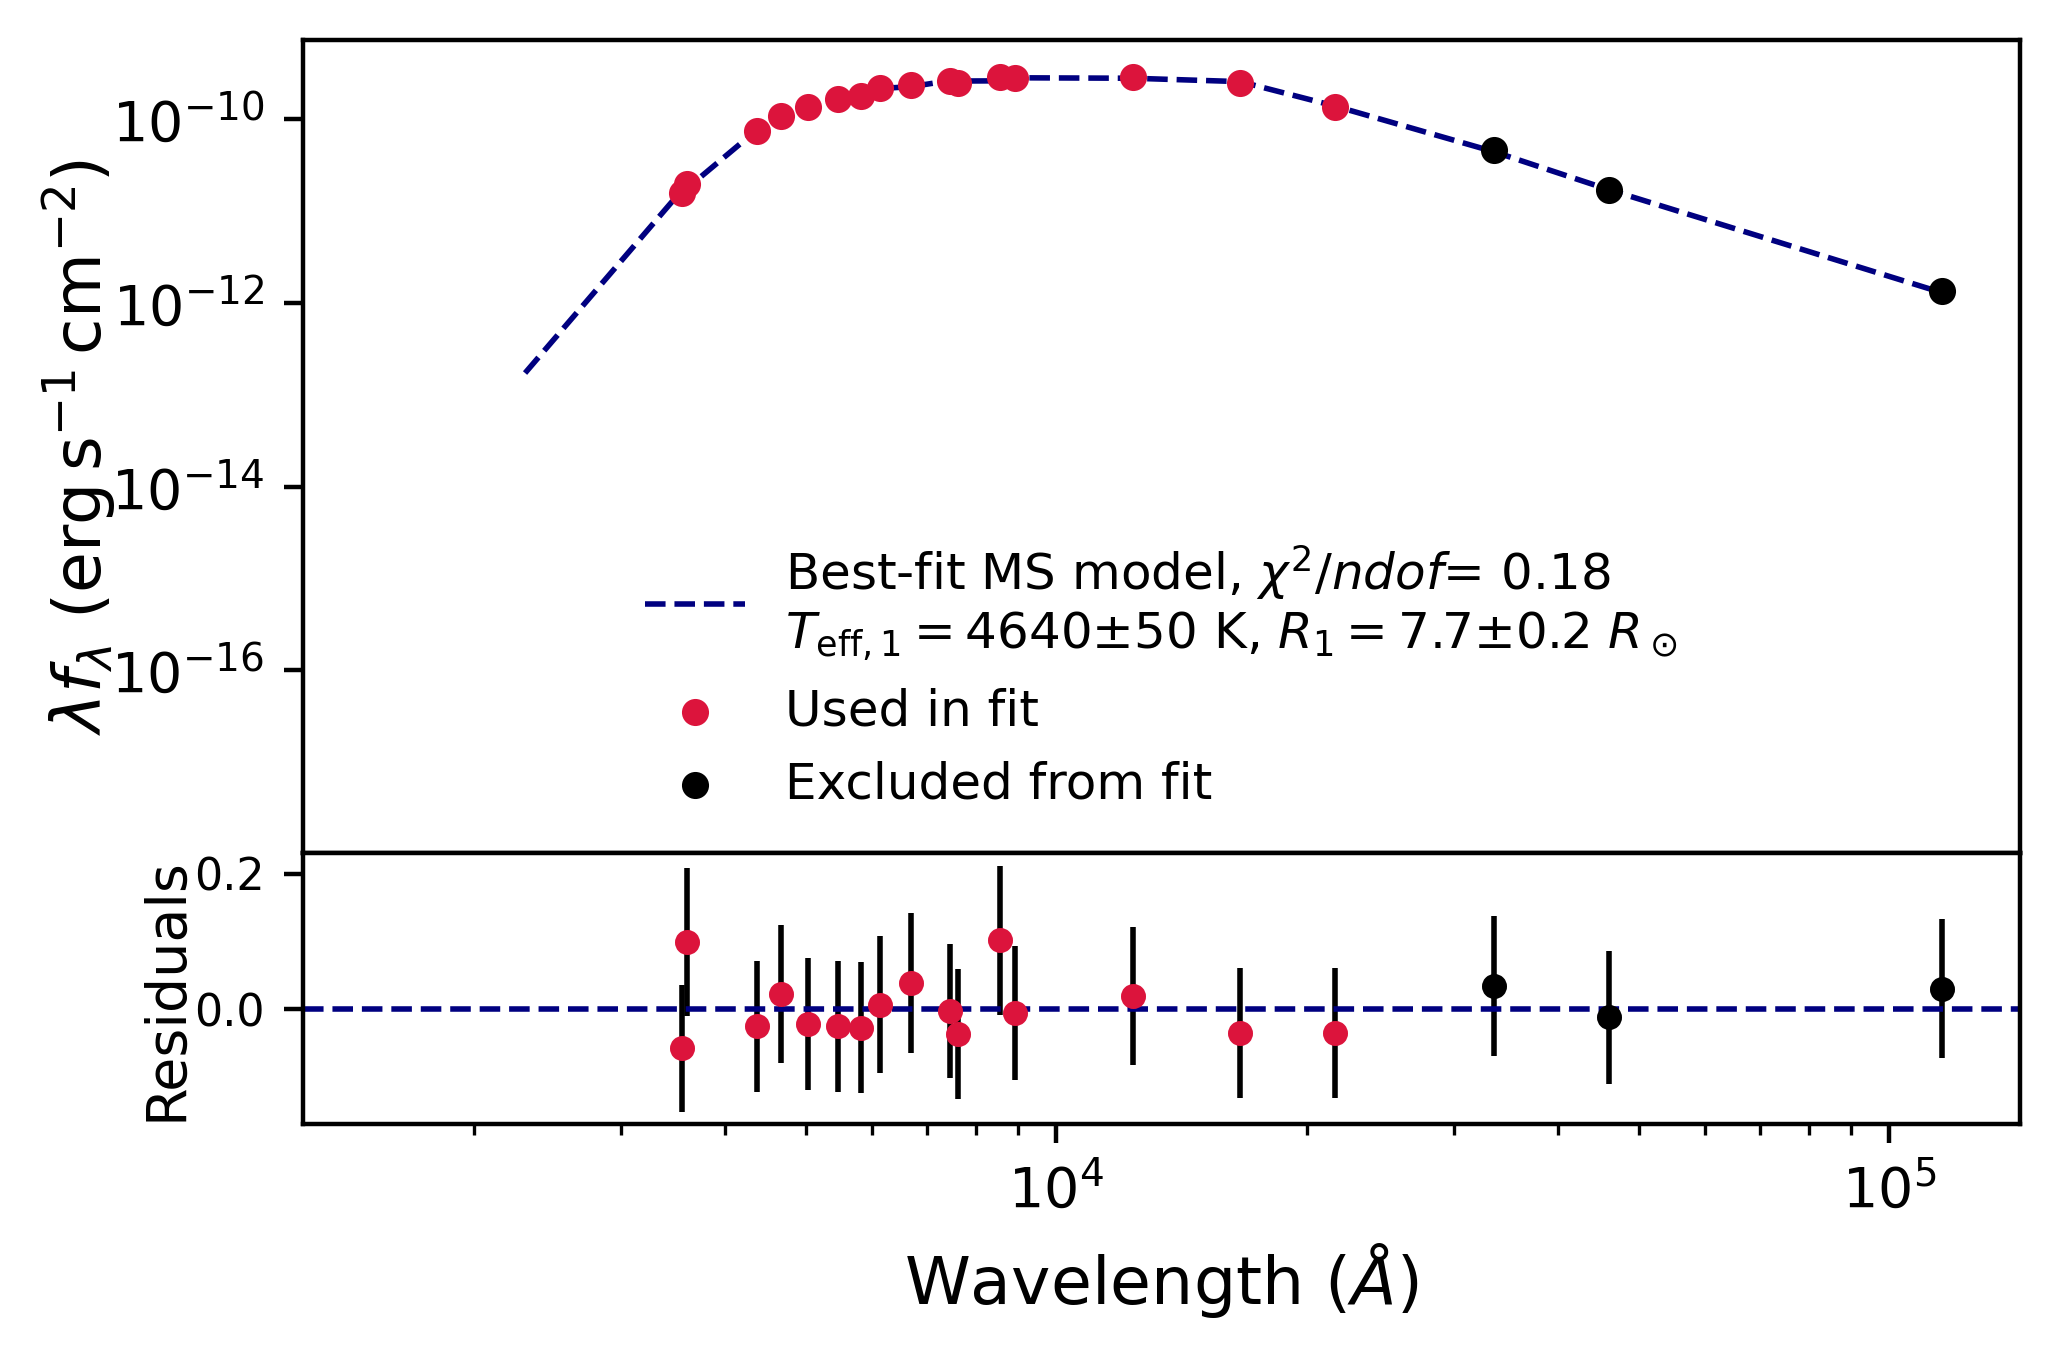

In [9]:
from SEDer import plotting_routines as pr
pr.plot_kurucz_fit(obs, meta, av, fit_results, 
                   source_id=None, parallax=obs['parallax'], bands_to_ignore=bands_to_ignore,
                   plot=True, save=False)

# Applying extinction to model flux OR color-magnitude
* Typically, the extinction is given in the Johnson V-band: $A_V$.
* One commonly needs the extinction in some other band X.
* The script extinction_routines.py does this conversion, through the so-called "extinction coefficients" $k_X = A_V/A_X$.
* $k_X$ depends on both $A_V$ AND the temperature of the source (approximation).
* The functions of extinction_routines.py accept $A_V$ and EITHER $T_{eff}$ OR the BP-RP color of the source (used to approximate the temperature).
* For extinction $A_X$, the model flux in the X band should be suppressed by the following factor:
$$F_X' = F_X \cdot 10^{-0.4\cdot A_X}$$
* Similarly, for extinction $A_X$ the model magnitude should be suppressed as follows:
$$X' = X + A_X $$
* For reddening $E(Y-Z)$ the model color changes as follows:
$$(Y-Z)' = (Y-Z) + E(Y-Z)$$

In [10]:
## Example of reddening model flux

teff_model = 5900 # temperature of model is known exactly, and determines the extinction coefficients
Gflux = sr.get_MS_sed(teff=teff_model, m1=1 , r1=1, meta=0, parallax=1.1538)['G3'] # G-band flux in physical units
Av = 0.1 # Assume some extinction in V-band; this could be provided by extinction maps or other sources
A_G,A_BP,A_RP = er.get_Gaia_extinction(Av,0,teff_model) # Get extinction coefficients for the model temperature

Gflux_reddened = Gflux * 10**(-0.4*A_G) # Apply extinction to the G-band flux
print(f'Model flux: {Gflux[0]*Gflux.unit:.2e}')
print(f'Reddened flux: {Gflux_reddened[0]*Gflux.unit:.2e}')

Model flux: 5.01e-15 erg / (Angstrom s cm2)
Reddened flux: 4.61e-15 erg / (Angstrom s cm2)


In [11]:
## Example of reddening model color+magnitude

Gmag = 10 # Assume some G-band magnitude (given by some model)
bprp_color = 1 # Assume some BP-RP color (given by some model)
Av = 0.5

A_G, E_BPRP = er.get_AG_EBPRP(Av,bprp_color) 

Gmag_reddened = Gmag + A_G
bprp_color_reddened = bprp_color + E_BPRP
print(f'Model G: {Gmag:.2f}')
print(f'Reddened G: {Gmag_reddened:.2f}')
print(f'Model BP-RP: {bprp_color:.2f}')
print(f'Reddened BP-RP: {bprp_color_reddened:.2f}')

Model G: 10.00
Reddened G: 10.40
Model BP-RP: 1.00
Reddened BP-RP: 1.22
